## 21/03/2021 EM algorithm with pytorch 


As previously described, in order to implement the model as per described in the paper, em algorithm must be used to iteratively learn the parameters of the distribution for the GMM model. 

Here we need to use the em algorithm to update the parameters for the mixture of gaussians model used to model the distribution of the normal sound. With this distribution, we can then use rejection sampling to get the anomalous distribution. 

EM algorithm is a difficult concept to understand

Here I will start with a rather basic example of the em algorithm to familiarise myself with the algorithm and its implementation in python, before implementing it in the pytorch np model. 


## 21/03/2021 

First we make some samples, with three clusters. This will be the underlying data we are trying to learn. The end result from the EM algorithm should be all the means and variances used here. The model would have no idea of these true underlying parameters and will try to estimate them. 

In [30]:
from mpl_toolkits.mplot3d import Axes3D

import torch 
import numpy as np 
def sample(mu, var, n_samples = 100):
    out  = [torch.normal(mu, var.sqrt()) for i in range(n_samples)]
    
    return torch.stack(out, dim = 0)

    
cluster1 = sample(torch.tensor([-0.5,-2.5]), torch.tensor([1.2,3.2]))
cluster2 = sample(torch.tensor([2.0,2.0]), torch.tensor([0.2,2.2]))
cluster3 = sample(torch.tensor([5.0, -4.2]), torch.tensor([1.1,0.9]))




## 21/03/2021 visualise the clusters 

The three clusters are shown in their respective classes in different colours. The gaussian mixture model would have no idea which datapoints below to which class. 

three distinct ish clusters are formed. 

c:\users\andy cai\appdata\local\programs\python\python36\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


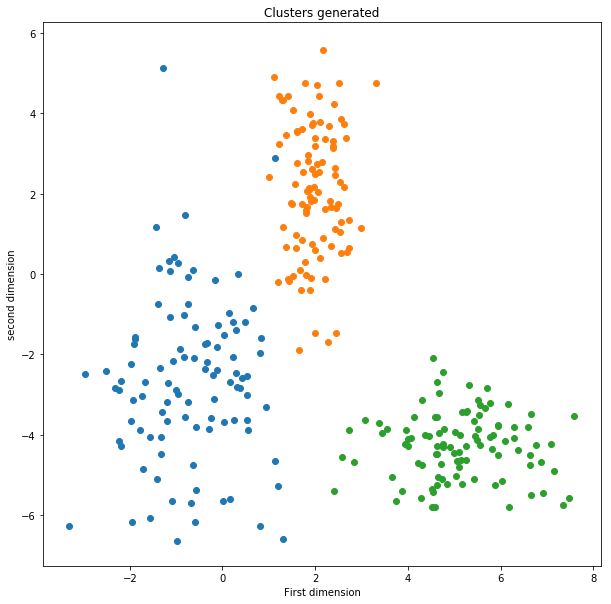

In [31]:
import matplotlib.pyplot as plt 

def display_2d(cluster, ax):
    ax.title.set_text("Clusters generated")
    ax.set_xlabel("First dimension")
    ax.set_ylabel("second dimension")
    ax.scatter(cluster.numpy()[:,0], cluster.numpy()[:,1])
    return 

fig, ax = plt.subplots(1,1, figsize=(10,10))

for cluster in [cluster1, cluster2, cluster3]:
    display_2d(cluster, ax)
    
fig.show()

## 21/03/2021 


The first step for the EM algorithm is to initialise it . This involves telling the algorithn how many clusters are there. in this case there will be three clusters. 

Three cluster centres will first be randomly selected by taking three datapoints randomly from all the samples 

The variances of all the gaussians will first be set to 1. 

The intialisation returns a list of gaussian means, a list of variances and pi, which is the prior c_m 

In [32]:
def initialize(data, K, var = 1):
    
    indx = torch.from_numpy(np.random.choice(data.size(0),K, replace = False)).long()
    print(indx)
    mu = data[indx]
    d = data.size(1)
    print(mu)
    
    # initialises the variance to the provided variance. default is 1 
    var = torch.Tensor(K,d).fill_(var)
    
    # initialises the prior. This is defaulted to a uniform.
    pi = torch.empty(K).fill_(1./K)
    
    return mu, var, pi

data = torch.cat((cluster1, cluster2, cluster3))
initialize(data, 3)
    

tensor([219, 139, 117])
tensor([[ 6.6289, -4.4973],
        [ 1.1049,  4.8938],
        [ 1.3025,  1.1715]])


(tensor([[ 6.6289, -4.4973],
         [ 1.1049,  4.8938],
         [ 1.3025,  1.1715]]), tensor([[1., 1.],
         [1., 1.],
         [1., 1.]]), tensor([0.3333, 0.3333, 0.3333]))

## 23/03/2021 


There is a log normalisation constant to define, which is the thing in front of the gaussian. 

various helper functions are defined: 

log_gaussian returns the component wise density of x under the distribution. tells you the density of each component of x under the gaussian. 



In [41]:


log_norm_constant = -0.5 * np.log(2 * np.pi)
def log_gaussian(x, mean = 0., logvar = 0.):
    '''
    This returns the component wise density of x under the distribution
    '''
    if isinstance(logvar, float):
        logvar = torch.new(1).fill_(logvar)
        
    a = (x-mean)**2
    
    log_p = log_norm_constant + -0.5*(logvar + a/logvar.exp())
    return log_p
    
    
def log_gaussian(x, mean=0, logvar=0.):
    """
    Returns the component-wise density of x under the gaussian parameterised
    by `mean` and `logvar`
    :param x: (*) torch.Tensor
    :param mean: float or torch.FloatTensor with dimensions (*)
    :param logvar: float or torch.FloatTensor with dimensions (*)
    :param normalize: include normalisation constant?
    :return: (*) log density
    """
    if type(logvar) == 'float':
        logvar = x.new(1).fill_(logvar)

    a = (x - mean) ** 2
    log_p = -0.5 * (logvar + a / logvar.exp())
    log_p = log_p + log_norm_constant

    return log_p    
def reparameterise(mu, logvar):
    '''
    This takes a sample from the distribution mu and logvar which still enables it to be back propagated. i.e the 
    vector obtained is differentiable with respect to mu and logvar. 
    
    This is done by drawing e from N(0,I) and doing a location-scale transform
    '''
    e = mu.new_empty(*mu.size()).normal_()
    std = (logvar*0.5).exp()
    
    return mu+e*std
    



## 21/03/2021 

Get_likelihoods computes the likelihood of each data point under each gaussian 

the output will be a k times sample size matrix showing how much each gaussian contributed to the likelihood of the data. 

get_posteriors will calculate teh posterior probability of the model parameters given the likelihoods of all the data. 



In [ ]:
    
def get_likelihoods(X, mu, logvar, log=True):
    """
    Compute the likelihood of each data point under each gaussians.
    :param X: design matrix (examples, features)
    :param mu: the component means (K, features)
    :param logvar: the component log-variances (K, features)
    :param log: return value in log domain?
        Note: exponentiating can be unstable in high dimensions.
    :return likelihoods: (K, examples)
    """
    
    # get feature-wise log-likelihoods (K, examples, features)
    log_likelihoods = log_gaussian(
        X[None, :, :], # (1, examples, features)
        mu[:, None, :], # (K, 1, features)
        logvar[:, None, :] # (K, 1, features)
    )
    
    # sum over the feature dimension
    log_likelihoods = log_likelihoods.sum(-1)
    
    if not log:
        log_likelihoods.exp_()

    return log_likelihoods


def get_posteriors(log_likelihoods, log_pi):
    """
    Calculate the the posterior probabities log p(z|x), assuming a uniform prior over
    components (for this step only).
    :param likelihoods: the relative likelihood p(x|z), of each data point under each mode (K, examples)
    :param log_pi: log prior (K)
    :return: the log posterior p(z|x) (K, examples)
    """
    posteriors = log_likelihoods # + log_pi[:, None]
    posteriors = posteriors - logsumexp(posteriors, dim=0, keepdim=True)
    return posteriors


    """
    :param X: design matrix (examples, features)
    :param log_posteriors: the log posterior probabilities p(z|x) (K, examples)
    :returns mu, var, pi: (K, features) , (K, features) , (K)
    """
    
    posteriors = log_posteriors.exp()

    # compute `N_k` the proxy "number of points" assigned to each distribution.
    K = posteriors.size(0)
    N_k = torch.sum(posteriors, dim=1) # (K)
    N_k = N_k.view(K, 1, 1)

    # get the means by taking the weighted combination of points
    # (K, 1, examples) @ (1, examples, features) -> (K, 1, features)
    mu = posteriors[:, None] @ X[None,]
    mu = mu / (N_k + eps)

    # compute the diagonal covar. matrix, by taking a weighted combination of
    # the each point's square distance from the mean
    A = X.unsqueeze(0) - mu
    print("A {}, X {}, mu {}".format(A.size(), X.size(), mu.size()))
    var = posteriors[:, None] @ (A ** 2) # (K, 1, features)
    var = var / (N_k + eps)
    logvar = torch.clamp(var, min=min_var).log()

    # recompute the mixing probabilities
    m = X.size(1) # nb. of training examples
    pi = N_k / N_k.sum()

    return mu.squeeze(1), logvar.squeeze(1), pi.squeeze()




def get_density(mu, logvar, pi, N=50, X_range=(0, 5), Y_range=(0, 5)):
    """ Get the mesh to compute the density on. """
    X = np.linspace(*X_range, N)
    Y = np.linspace(*Y_range, N)
    X, Y = np.meshgrid(X, Y)
    
    # get the design matrix
    points = np.concatenate([X.reshape(-1, 1), Y.reshape(-1, 1)], axis=1)
    
    points = torch.from_numpy(points).float()
    print(points.size())
    
    # compute the densities under each mixture
    P = get_likelihoods(points, mu, logvar, log=False)
    print(P.size())
    # sum the densities to get mixture density
    Z = torch.sum(P, dim=0).data.numpy().reshape([N, N])
    
    return X, Y, Z



def plot_density(X, Y, Z, i=0):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True)
    cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.15)

    # adjust the limits, ticks and view angle
    ax.set_zlim(-0.15,0.2)
    ax.set_zticks(np.linspace(0,0.2,5))
    ax.view_init(27, -21)
#     plt.savefig('fig_{}.png'.format(i), dpi=400, bbox_inches='tight')
    plt.show()
    
    
def logsumexp(x, dim, keepdim=False):
    """
    :param x:
    :param dim:
    :param keepdim:
    :return:
    """
    max, _ = torch.max(x, dim=dim, keepdim=True)
    out = max + (x - max).exp().sum(dim=dim, keepdim=keepdim).log()
    return out
   
    
def get_parameters(X, log_posteriors, eps=1e-6, min_var=1e-6):
    """
    :param X: design matrix (examples, features)
    :param log_posteriors: the log posterior probabilities p(z|x) (K, examples)
    :returns mu, var, pi: (K, features) , (K, features) , (K)
    """
    
    posteriors = log_posteriors.exp()

    # compute `N_k` the proxy "number of points" assigned to each distribution.
    K = posteriors.size(0)
    N_k = torch.sum(posteriors, dim=1) # (K)
    N_k = N_k.view(K, 1, 1)

    # get the means by taking the weighted combination of points
    # (K, 1, examples) @ (1, examples, features) -> (K, 1, features)
    mu = posteriors[:, None] @ X[None,]
    mu = mu / (N_k + eps)

    # compute the diagonal covar. matrix, by taking a weighted combination of
    # the each point's square distance from the mean
    A = X.unsqueeze(0) - mu
    print("A {}, X {}, mu {}".format(A.size(), X.size(), mu.size()))
    var = posteriors[:, None] @ (A ** 2) # (K, 1, features)
    var = var / (N_k + eps)
    logvar = torch.clamp(var, min=min_var).log()

    # recompute the mixing probabilities
    m = X.size(1) # nb. of training examples
    pi = N_k / N_k.sum()

    return mu.squeeze(1), logvar.squeeze(1), pi.squeeze()

## 23/03/2021 

the plot density things will allow things to ve visualised 

A set number of iterations was completed. 

it can be seen that the model was able to converge successfully to the set of underlying parameters we started with, so this algorithm works and is implemented correctly. 

The next step is to implement this in the NP lemma based model to estimate the mixture of gaussian model which represents normal operation noise. 

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

tensor([258, 127, 222])
tensor([[ 3.9325, -4.2236],
        [ 1.6550, -1.8880],
        [ 5.0981, -4.4225]])
torch.Size([10000, 2])
torch.Size([3, 10000])


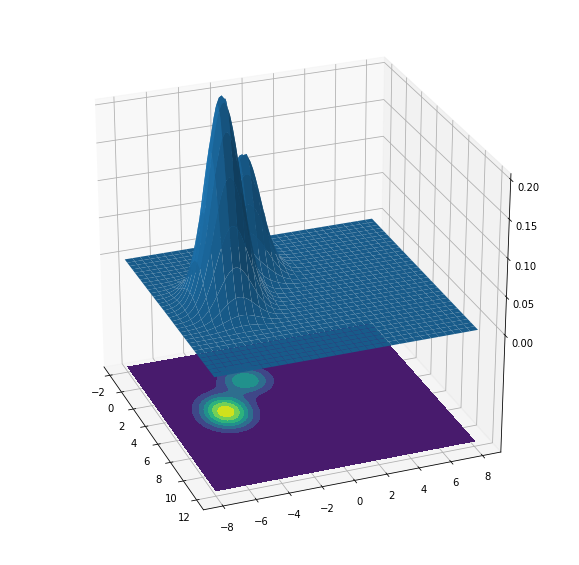

  2%|█▋                                                                                 | 1/50 [00:00<00:25,  1.95it/s]

A torch.Size([3, 300, 2]), X torch.Size([300, 2]), mu torch.Size([3, 1, 2])
torch.Size([10000, 2])
torch.Size([3, 10000])


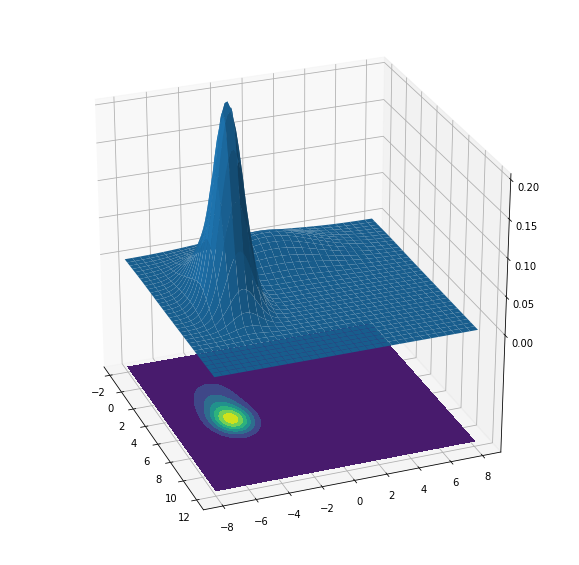

  4%|███▎                                                                               | 2/50 [00:01<00:25,  1.89it/s]

A torch.Size([3, 300, 2]), X torch.Size([300, 2]), mu torch.Size([3, 1, 2])
torch.Size([10000, 2])
torch.Size([3, 10000])


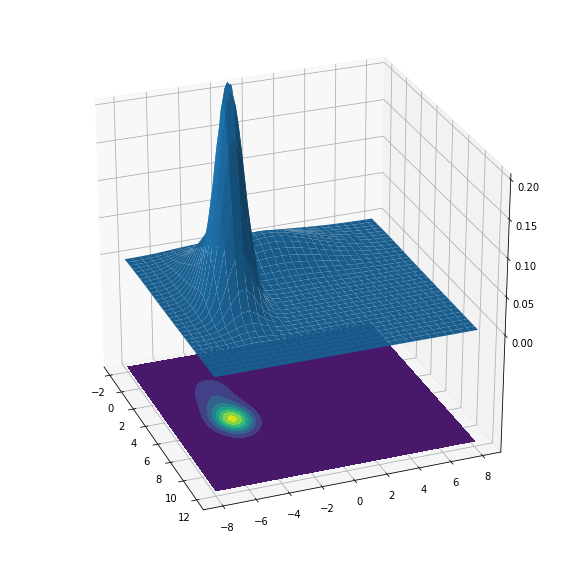

  6%|████▉                                                                              | 3/50 [00:01<00:24,  1.90it/s]

A torch.Size([3, 300, 2]), X torch.Size([300, 2]), mu torch.Size([3, 1, 2])
torch.Size([10000, 2])
torch.Size([3, 10000])


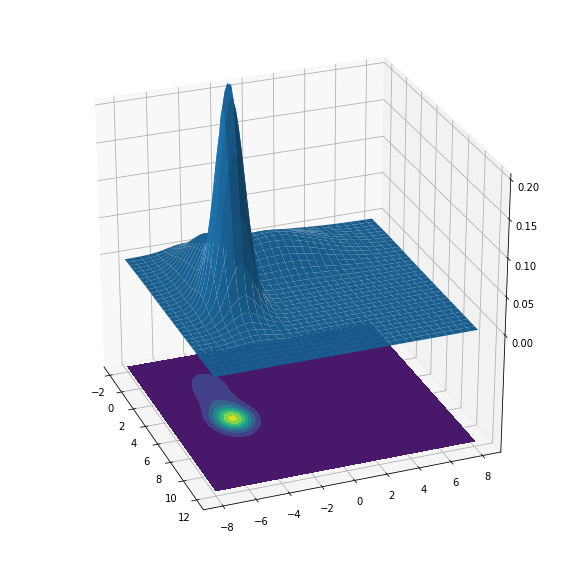

  8%|██████▋                                                                            | 4/50 [00:02<00:25,  1.81it/s]

A torch.Size([3, 300, 2]), X torch.Size([300, 2]), mu torch.Size([3, 1, 2])
torch.Size([10000, 2])
torch.Size([3, 10000])


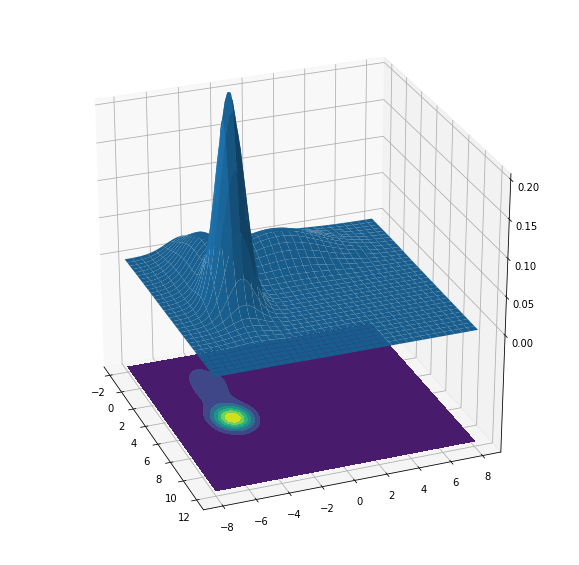

 10%|████████▎                                                                          | 5/50 [00:02<00:24,  1.83it/s]

A torch.Size([3, 300, 2]), X torch.Size([300, 2]), mu torch.Size([3, 1, 2])
torch.Size([10000, 2])
torch.Size([3, 10000])


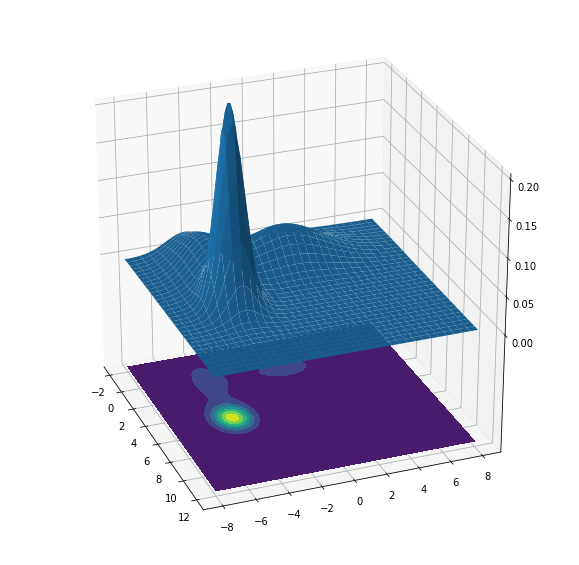

 12%|█████████▉                                                                         | 6/50 [00:03<00:24,  1.83it/s]

A torch.Size([3, 300, 2]), X torch.Size([300, 2]), mu torch.Size([3, 1, 2])
torch.Size([10000, 2])
torch.Size([3, 10000])


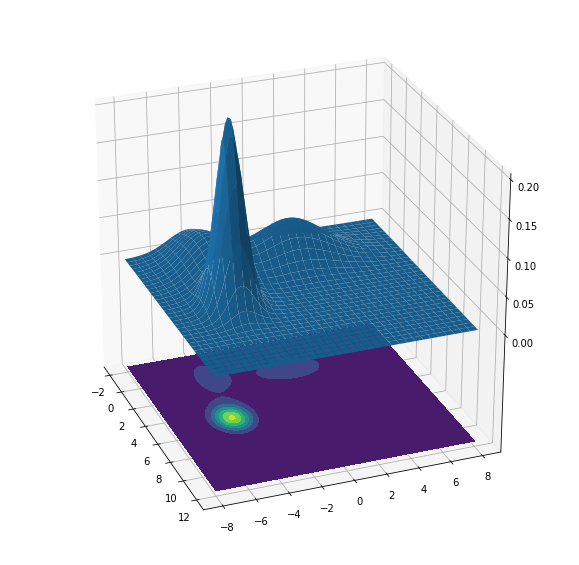

 14%|███████████▌                                                                       | 7/50 [00:03<00:22,  1.88it/s]

A torch.Size([3, 300, 2]), X torch.Size([300, 2]), mu torch.Size([3, 1, 2])
torch.Size([10000, 2])
torch.Size([3, 10000])


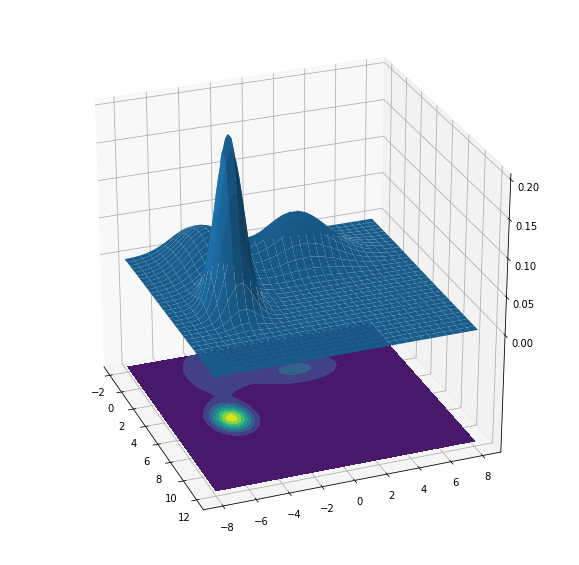

 16%|█████████████▎                                                                     | 8/50 [00:04<00:23,  1.78it/s]

A torch.Size([3, 300, 2]), X torch.Size([300, 2]), mu torch.Size([3, 1, 2])
torch.Size([10000, 2])
torch.Size([3, 10000])


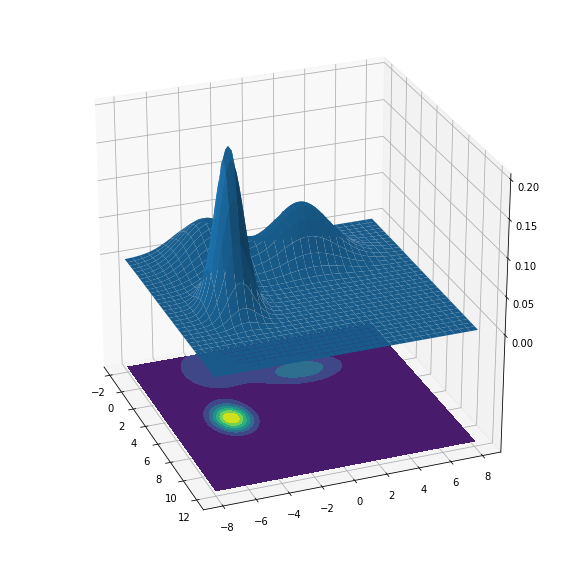

 18%|██████████████▉                                                                    | 9/50 [00:05<00:23,  1.73it/s]

A torch.Size([3, 300, 2]), X torch.Size([300, 2]), mu torch.Size([3, 1, 2])
torch.Size([10000, 2])
torch.Size([3, 10000])


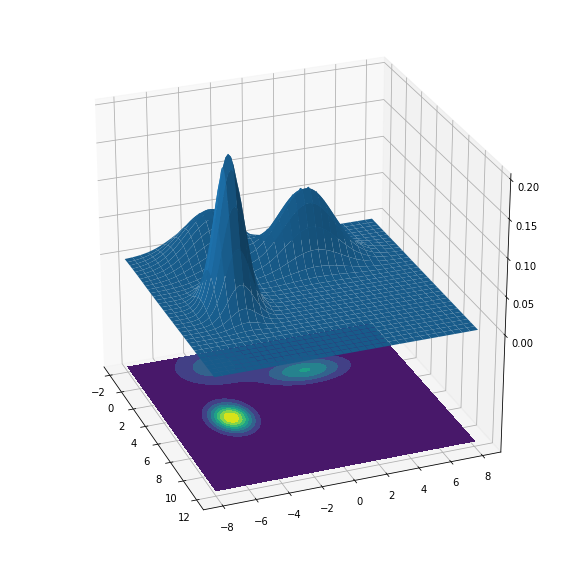

 20%|████████████████▍                                                                 | 10/50 [00:05<00:23,  1.71it/s]

A torch.Size([3, 300, 2]), X torch.Size([300, 2]), mu torch.Size([3, 1, 2])
torch.Size([10000, 2])
torch.Size([3, 10000])


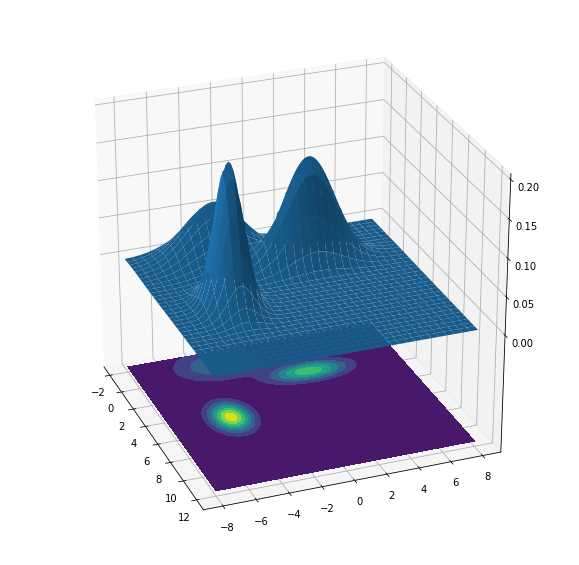

 22%|██████████████████                                                                | 11/50 [00:06<00:23,  1.65it/s]

A torch.Size([3, 300, 2]), X torch.Size([300, 2]), mu torch.Size([3, 1, 2])
torch.Size([10000, 2])
torch.Size([3, 10000])


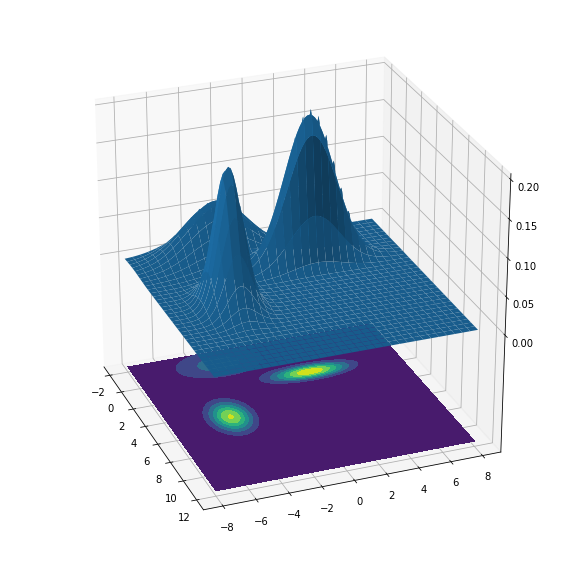

 24%|███████████████████▋                                                              | 12/50 [00:06<00:22,  1.72it/s]

A torch.Size([3, 300, 2]), X torch.Size([300, 2]), mu torch.Size([3, 1, 2])
torch.Size([10000, 2])
torch.Size([3, 10000])


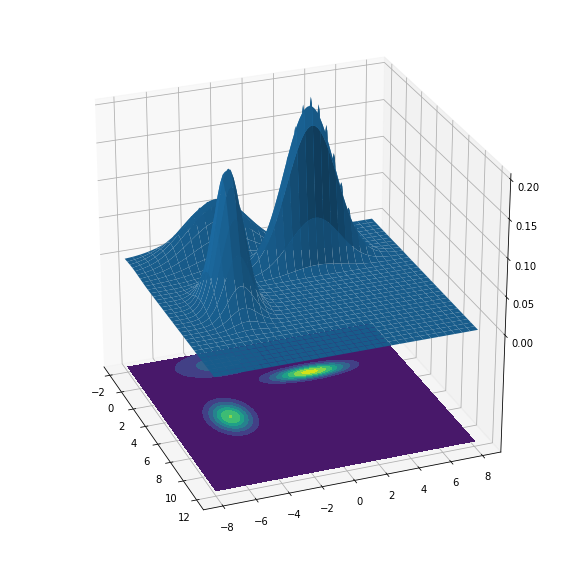

 26%|█████████████████████▎                                                            | 13/50 [00:07<00:21,  1.74it/s]

A torch.Size([3, 300, 2]), X torch.Size([300, 2]), mu torch.Size([3, 1, 2])
torch.Size([10000, 2])
torch.Size([3, 10000])


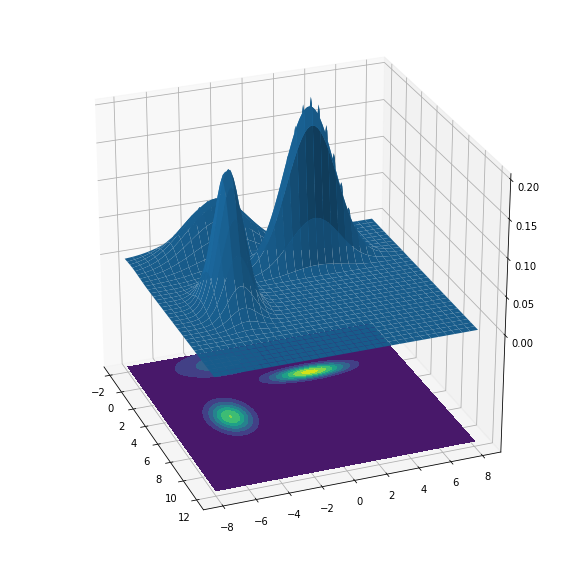

 28%|██████████████████████▉                                                           | 14/50 [00:07<00:20,  1.74it/s]

A torch.Size([3, 300, 2]), X torch.Size([300, 2]), mu torch.Size([3, 1, 2])
torch.Size([10000, 2])
torch.Size([3, 10000])


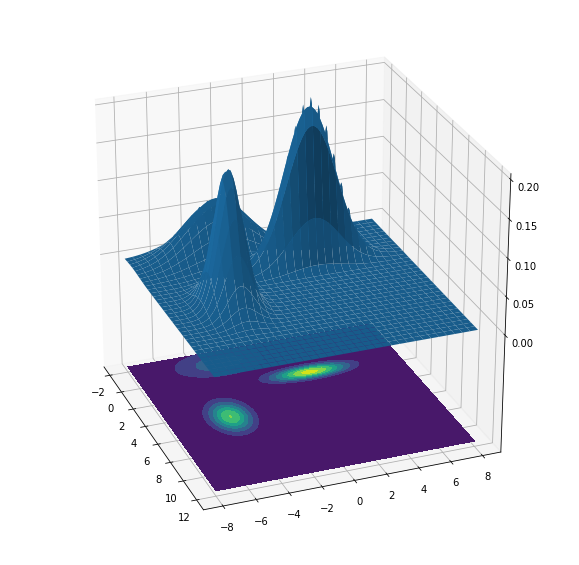

 30%|████████████████████████▌                                                         | 15/50 [00:08<00:19,  1.76it/s]

A torch.Size([3, 300, 2]), X torch.Size([300, 2]), mu torch.Size([3, 1, 2])
torch.Size([10000, 2])
torch.Size([3, 10000])


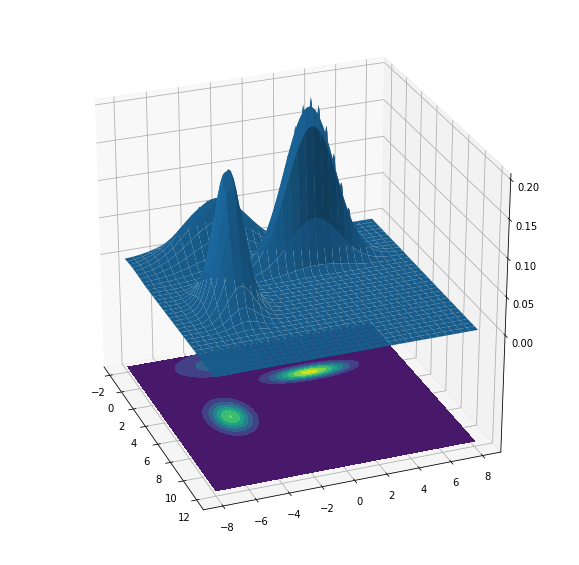

 32%|██████████████████████████▏                                                       | 16/50 [00:09<00:18,  1.79it/s]

A torch.Size([3, 300, 2]), X torch.Size([300, 2]), mu torch.Size([3, 1, 2])
torch.Size([10000, 2])
torch.Size([3, 10000])


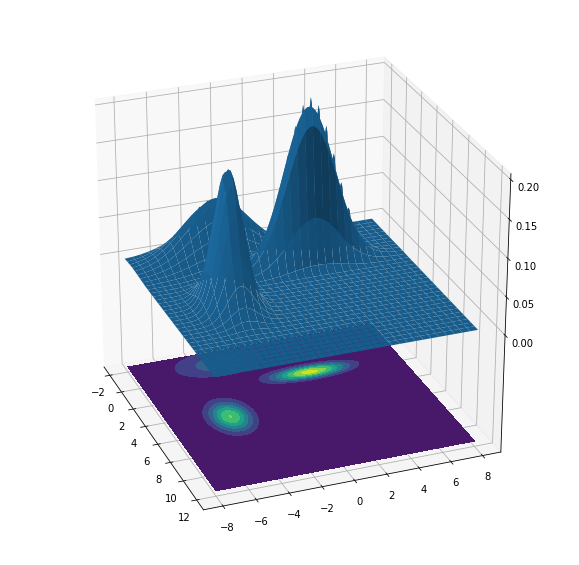

 34%|███████████████████████████▉                                                      | 17/50 [00:09<00:19,  1.69it/s]

A torch.Size([3, 300, 2]), X torch.Size([300, 2]), mu torch.Size([3, 1, 2])
torch.Size([10000, 2])
torch.Size([3, 10000])


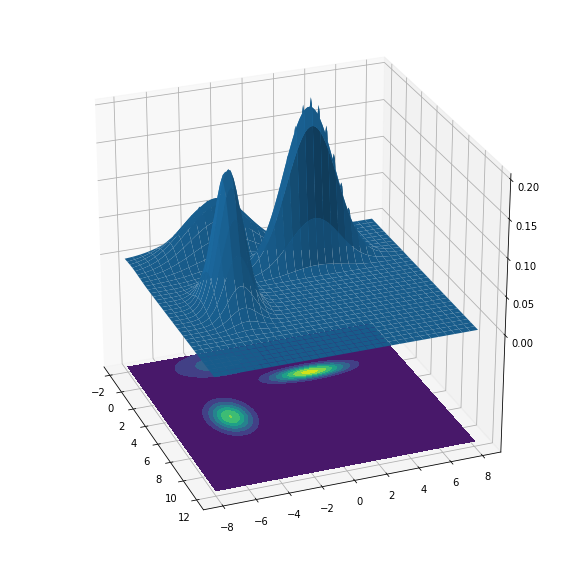

 36%|█████████████████████████████▌                                                    | 18/50 [00:10<00:18,  1.71it/s]

A torch.Size([3, 300, 2]), X torch.Size([300, 2]), mu torch.Size([3, 1, 2])
torch.Size([10000, 2])
torch.Size([3, 10000])


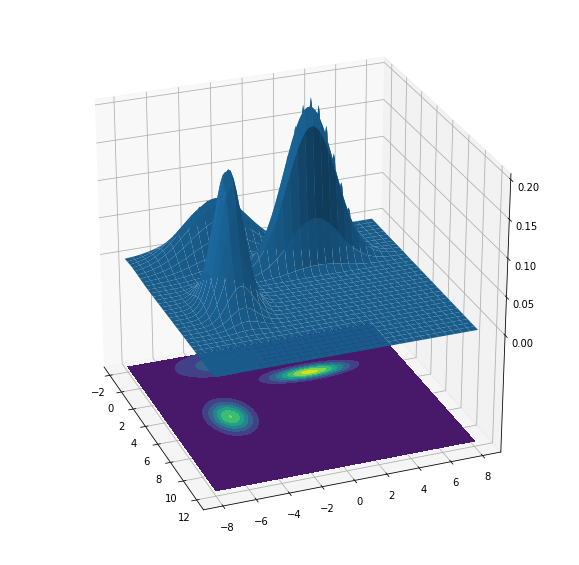

 38%|███████████████████████████████▏                                                  | 19/50 [00:10<00:18,  1.65it/s]

A torch.Size([3, 300, 2]), X torch.Size([300, 2]), mu torch.Size([3, 1, 2])
torch.Size([10000, 2])
torch.Size([3, 10000])


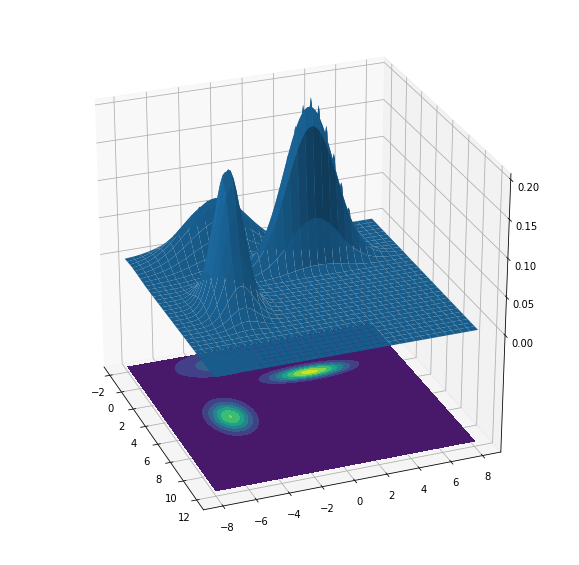

 40%|████████████████████████████████▊                                                 | 20/50 [00:11<00:17,  1.67it/s]

A torch.Size([3, 300, 2]), X torch.Size([300, 2]), mu torch.Size([3, 1, 2])
torch.Size([10000, 2])
torch.Size([3, 10000])


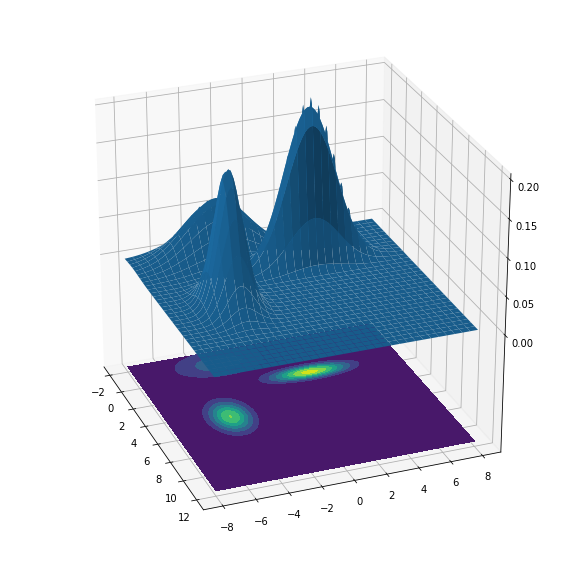

 42%|██████████████████████████████████▍                                               | 21/50 [00:12<00:17,  1.69it/s]

A torch.Size([3, 300, 2]), X torch.Size([300, 2]), mu torch.Size([3, 1, 2])
torch.Size([10000, 2])
torch.Size([3, 10000])


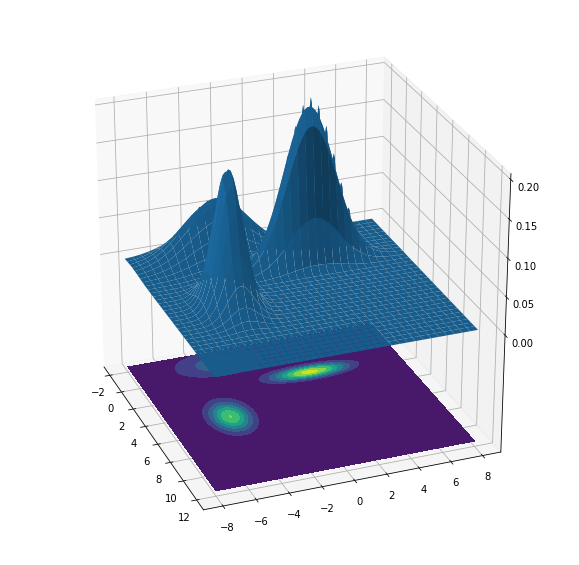

In [44]:
 
from tqdm import tqdm

k = 3
d = 2
nb_iters = 50

mu, var, pi = initialize(data, k, var=1)
logvar = var.log()

prev_cost = float('inf')
thresh = 1e-5
for i in tqdm(range(nb_iters)):
    # get the likelihoods p(x|z) under the parameters
    log_likelihoods = get_likelihoods(data, mu, logvar)
    
    # plot!
    plot_density(*get_density(mu, logvar, pi, N=100, X_range=(-2, 12), Y_range=(-8, 8)), i=i)
    
    # compute the "responsibilities" p(z|x)
    log_posteriors = get_posteriors(log_likelihoods, pi.log())
    
    # compute the cost and check for convergence
    cost = log_likelihoods.mean()
    diff = prev_cost - cost
    if torch.abs(diff).item() < thresh:
        break
    prev_cost = cost
    
    # re-compute parameters
    mu, logvar, pi = get_parameters(data, log_posteriors)